# Convolutional Neural Networks

Having previously delved into text sentiment analysis using classical methods and simpler neural networks, this notebook ventures into the visual domain - **image classification**. 

The star of this show is the **Convolutional Neural Network (CNN)**, an architecture specifically designed to understand and interpret visual information. Unlike our previous text-based models, it excels at recognizing patterns, and hierarchical features directly from pixel data. 

Our humble goal here is to build a simple CNN from scratch, understand its fundamental components, and train it to distinguish between ten different categories of everyday objects using a relatively small dataset.

## Data Preparation

For this specific task we will load the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which is conveniently available through Keras.

In [1]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

This dataset consists of 60,000 images in 10 classes, with 6,000 images per class. In our specific case, the dataset is already split into two subsets - training and test (50,000 and 10,000 samples). Unfortunately, those classes are labeled using simple digits, but we can tag them in a human-readable manner ourselves. Doing so would help us to interpret the results later.

In [2]:
class_names = [
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
]

Let's visualize a few training images to get a feel for the data.

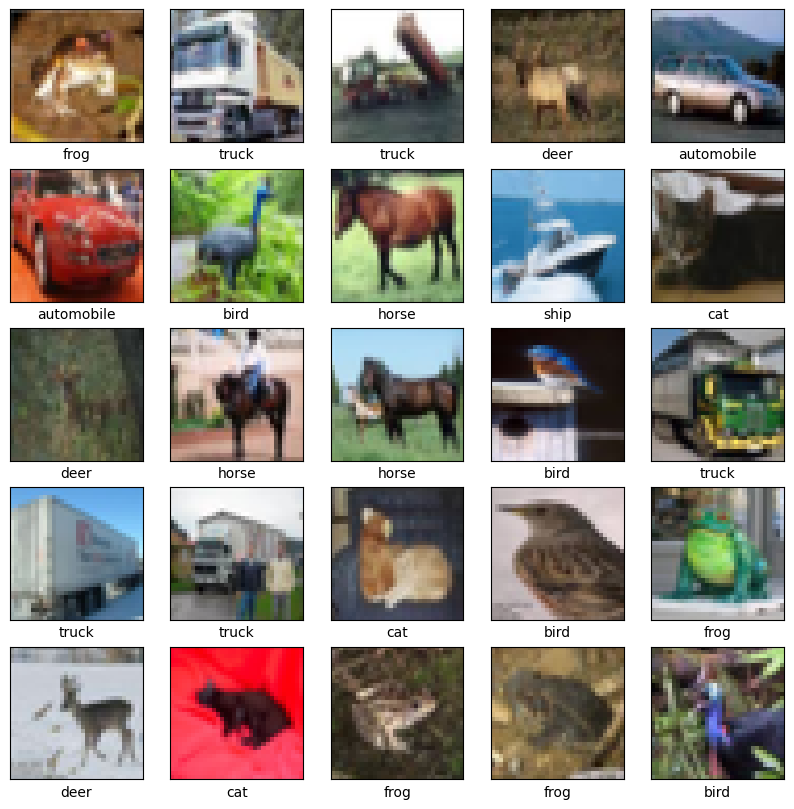

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 10])

for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[y_train[i][0]])

plt.show()

In [4]:
display(x_train[0].shape)
display(x_train[0])

(32, 32, 3)

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

From a technical perspective, each sample (image) is a 32x32 grid of pixels, each encoded using [three RGB channels](https://en.wikipedia.org/wiki/RGB_color_model) (with their values ranging from 0 to 255). It may be an issue, because features with larger numerical values may disproportionately influence the model's weight updates. Therefore, **normalizing** them to a smaller range (commonly 0 to 1) would be a good idea.

In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

## Label Encoding

In [6]:
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes=len(class_names))
y_test_encoded = to_categorical(y_test, num_classes=len(class_names))

## Building and Training the Model

Now, let's construct our CNN. 

That type of neural networks is particularly well-suited for image data because it uses specialized layers to automatically and adaptively learn spatial hierarchies of features – from edges and textures in earlier layers to more complex patterns and object parts in deeper layers.

Our architecture will consist of two sequential sub-models:

- **Feature Learning:** The eyes of the network. This part is responsible for taking the raw pixel data from the input image and gradually extracting increasingly complex and abstract visual patterns. Much like how your own visual cortex detects edges, textures, and simple shapes before your brain starts to assemble them into recognizable objects. This is achieved by flowing data through multiple similar stages:

    - **Convolutional Layer:** This is the core feature detector. It applies a set of learnable filters (kernels) to the input image. Each filter slides across the image, performing a convolution operation to detect specific features like edges, corners, or textures. Early layers might detect simple lines, deeper ones combine those into more complex shapes like corners or curves.

    - **Max Pooling Layer:** After a convolutional layer has identified a bunch of features, max pooling helps to generalize and condense this information. It looks at small windows of the feature map and picks out the strongest response (the "max" value). This makes the learned features more robust to variations and greatly reduces computational complexity.

- **Classification:** The brain of the network. Once the feature learning part has extracted a rich set of abstract features from the image, this sub-model takes those high-level features and makes a decision about what object the image actually contains. Conceptually, it's very close to our [Multilayer Perceptron](sentiment/03-mlp.ipynb) attempt, but this time it classifies visual clues instead of words.

In [7]:
from tensorflow.keras import layers, Sequential
num_classes = len(class_names)
input_shape = x_train.shape[1:]

feature_learning = Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
])

classification = Sequential([
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax'),
])

model = Sequential([
    feature_learning,
    classification,
])

We can train our model now.

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train_encoded, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.2741 - loss: 1.9543 - val_accuracy: 0.5011 - val_loss: 1.3840
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.4911 - loss: 1.4149 - val_accuracy: 0.5683 - val_loss: 1.2042
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5749 - loss: 1.2002 - val_accuracy: 0.6588 - val_loss: 0.9629
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.6269 - loss: 1.0570 - val_accuracy: 0.6819 - val_loss: 0.9353
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6604 - loss: 0.9737 - val_accuracy: 0.6907 - val_loss: 0.8833
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6926 - loss: 0.8852 - val_accuracy: 0.7215 - val_loss: 0.8097
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.7120 - loss: 0.8232 - val_accuracy: 0.7226 - val_loss: 0.8124
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.7351 - loss: 0.7558 - 

## Result

In [9]:
from sklearn.metrics import classification_report
import numpy as np
y_pred_probs = model.predict(x_test, verbose=False)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_encoded, axis=1)
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.74      0.82      0.78      1000
  automobile       0.86      0.86      0.86      1000
        bird       0.61      0.69      0.65      1000
         cat       0.55      0.58      0.56      1000
        deer       0.67      0.72      0.69      1000
         dog       0.70      0.57      0.63      1000
        frog       0.79      0.83      0.81      1000
       horse       0.81      0.75      0.78      1000
        ship       0.88      0.80      0.84      1000
       truck       0.85      0.78      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



## Conclusion

With a respectable **~75% accuracy** on the CIFAR-10 test set, our relatively straightforward CNN has demonstrated its ability to learn meaningful visual features and classify images, even without extensive tuning or advanced architectures. 

This experiment clearly demonstrates  how convolutional and pooling layers work together to extract hierarchical patterns, and how a dense classifier can then make sense of these learned features.

Looking at the training history, we can observe the training accuracy steadily increasing. However, the validation accuracy appears to plateau or slightly decrease in later epochs, suggesting that the model is starting to overfit to the training data. This suggests a clear need for data augmentation and regularization (batch normalization, more dropouts) to combat this and potentially improve generalization.